# SugNet

## A U-Net based convnet for sugar beets crop/weeds detection.

[@ohidaoui](https://github.com/ohidaoui/)

-------

## Setup

First, let's import some modules, ensure MatplotLib plots figures inline, define some global variables (different data paths and the number of classes) and prepare two functions for plotting and saving figures.

In [1]:
import os
import glob
import cv2
import numpy as np
import random
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.metrics import MeanIoU, Accuracy
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
n_classes = 3 # Number of classes

In [4]:
def plot_image(image, cmap="viridis"):
    plt.imshow(image, cmap=cmap, interpolation="nearest")
    plt.axis("off")
    
SAVED_IMAGES_PATH = "saved_images"
os.makedirs(SAVED_IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(SAVED_IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Getting and preparing the Data

In [82]:
def crop_img(img, cropx=256, cropy=256):
    y,x = img.shape[:2]
    im1 = img[:cropy, :cropx, ...]
    im2 = img[(y-cropy):, :cropx, ...]
    im3 = img[:cropy, (x-cropx):, ...]
    im4 = img[(y-cropy):, (x-cropx):, ...]
    return [im1, im2, im3, im4]

### Coverting the images to grayscale, cropping them, and storing the 4 patches on disk

In [5]:
train_images_path = os.path.join('data', 'train_images', 'train')
val_images_path = os.path.join('data', 'val_images', 'val')
test_images_path = os.path.join('data', 'test_images', 'test')
train_masks_path = os.path.join('data', 'train_masks', 'train')
val_masks_path = os.path.join('data', 'val_masks', 'val')
test_masks_path = os.path.join('data', 'test_masks', 'test')

cropped_train_images_path = os.path.join('cropped_data', 'train_images', 'train')
cropped_val_images_path = os.path.join('cropped_data', 'val_images', 'val')
cropped_test_images_path = os.path.join('cropped_data', 'test_images', 'test')
cropped_train_masks_path = os.path.join('cropped_data', 'train_masks', 'train')
cropped_val_masks_path = os.path.join('cropped_data', 'val_masks', 'val')
cropped_test_masks_path = os.path.join('cropped_data', 'test_masks', 'test')

In [ ]:
def save_croped_images(input_path, output_path):
    with os.scandir(input_path) as entries:
        for entry in entries:
            basename = entry.name.split('.')
            assert (len(basename) == 2 and basename[1] == 'png')
            image = cv2.imread(os.path.join(input_path, entry.name), 0)
            img_patches = crop_img(image)
            basename = entry.name.split('.')
            for i in range(4):
                cv2.imwrite(os.path.join(output_path, basename[0] + '_' + str(i+1) + '.png'), img_patches[i])

In [ ]:
save_croped_images(train_images_path, cropped_train_images_path)
save_croped_images(train_masks_path, cropped_train_masks_path)

In [ ]:
save_croped_images(val_images_path, cropped_val_images_path)
save_croped_images(val_masks_path, cropped_val_masks_path)

In [ ]:
save_croped_images(test_images_path, cropped_test_images_path)
save_croped_images(test_masks_path, cropped_test_masks_path)

## Custom data generator

In [6]:
batch_size = 8

In [7]:
def read_images(img_dir, img_names_list):
    """
    read_images reads a list of images and returns a 4-dim tensor containing grayscale 256x256 images.
    """
    images = []
    for i, img_name in enumerate(img_names_list):
        img_path = os.path.join(img_dir, img_name)
        images.append(cv2.imread(img_path, 0))
    return np.expand_dims(np.array(images, dtype=np.float16), axis = 3)

def categorize_masks(masks, n_classes=n_classes):
    """
    categorize_masks converts masks (indexed images of values 0, 1 and 2) to categorical.
    """
    masks_cat = to_categorical(masks, num_classes=n_classes)
    return masks_cat.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    """
    Image data generator : generates sequentially a tuple of images and their corresponding masks (X,Y)
    X is of shape (batch_size, 256, 256, 1)
    Y is of shape (batch_size, 256, 256, 3)
    """
    L = len(img_list)

    # keras data generator must be infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = read_images(img_dir, img_list[batch_start:limit]) / 148. # rescaling from [min=0,max=148] to [0,1]
            Y = categorize_masks(read_images(mask_dir, mask_list[batch_start:limit]))
            
            yield (X,Y)

            batch_start += batch_size   
            batch_end += batch_size

In [8]:
train_img_list = os.listdir(cropped_train_images_path)  # basenames of the training images
val_img_list = os.listdir(cropped_val_images_path)  # basenames of the training images

In [9]:
# Note: each image has the same basename as its corresponding mask

train_img_datagen = imageLoader(cropped_train_images_path, train_img_list, 
                                cropped_train_masks_path, train_img_list, batch_size)

val_img_datagen = imageLoader(cropped_val_images_path, val_img_list, 
                              cropped_val_masks_path, val_img_list, batch_size)

In [ ]:
# x, y = train_img_datagen.__next__()

In [ ]:
# x.shape, y.shape

### The Sørensen–Dice coefficient
The Sørensen–Dice coefficient is used as a metric to track the accuracy of the segmentation.

- Given two sets, $X$ and $Y$, it is defined as :
$$
DSC = \frac {2|X\cap Y|}{|X|+|Y|}
$$

In [10]:
from keras import backend as K

In [11]:
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    return 2*intersection / union

### The Focal Loss
To face the large class imbalance present in the dataset, the $α$-balanced Focal Loss is used during training:

$$
\text{FL}(p^{(t)}, y^{(t)}) = -\sum_{c=0}^{m-1} {\alpha_c \ (1-p_c^{(t)})^\gamma \ y_c^{(t)} \ \log(p_c^{(t)})}
$$
Where $m$ is the number of classes, $c$ is the class, $t$ refers to the observation, $\gamma$ is the focusing parameter and $\alpha$ is the weighing factor.

[Original paper](https://arxiv.org/pdf/1708.02002.pdf)

In [12]:
def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

## Building the model

This U-shaped architecture consists of a specific encoder-decoder scheme: The encoder reduces the spatial dimensions in every layer and increases the channels. On the other hand, the decoder increases the spatial dims while reducing the channels. In the end, the spatial dims are restored to make a prediction for each pixel in the input image.

- **Encoder (left side):**  
It consists of the repeated application of two 3x3 convolutions. Each conv is followed by a ReLU, batch normalization and a SAME 2x2 max pooling operation. Again, at each downsampling step, we double the number of feature channels, while we cut in half the spatial dimensions.

- **Decoder path (right side):**  
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 transpose convolution, which halves the number of feature channels. We also have a concatenation with the corresponding feature map from the contracting path, and two 3x3 convolutional layers (each followed by ReLU + batch normalization). At the final layer, a 1x1 convolution is used to map the channels to the desired number of classes.

<p align="center"><img width="75%" src="sugnet_architecture.png"></p>

In [13]:
def conv_block(input, num_filters, kernel_reg_rate=None):
    kernel_reg = None if kernel_reg_rate is None else L2(kernel_reg_rate)
    
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal', 
               kernel_regularizer=kernel_reg)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer = 'he_normal', 
               kernel_regularizer=kernel_reg)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters, reg_rate=None):
    x = conv_block(input, num_filters, reg_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters, reg_rate=None):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    min_shape = min(x.shape[1], skip_features.shape[1])
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, reg_rate)
    return x

def unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64, reg_rate=2e-4)
    dr1 = Dropout(0.05)(p1, training=True)
    s2, p2 = encoder_block(dr1, 128, reg_rate=6e-4)
    dr2 = Dropout(0.1)(p2, training=True)
    s3, p3 = encoder_block(dr2, 256, reg_rate=1e-3)

    dr3 = Dropout(0.2)(p3, training=True)
    b1 = conv_block(dr3, 512) 

    d1 = decoder_block(b1, s3, 256, reg_rate=1e-3)
    dr4 = Dropout(0.2)(d1, training=True)
    d3 = decoder_block(dr4, s2, 128, reg_rate=6e-4)
    dr4 = Dropout(0.1)(d3, training=True)
    d4 = decoder_block(dr4, s1, 64, reg_rate=2e-4)

    outputs = Conv2D(n_classes, 1, padding="same", activation='softmax')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [14]:
input_shape = (256, 256, 1)

In [15]:
model = unet(input_shape, n_classes=n_classes)

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=[categorical_focal_loss(alpha=[[.2, .4, .4]], gamma=2)], 
              metrics=[dice_metric])

In [81]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 256)  524544     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 512)  0           ['conv2d_transpose[0][0]',       
                                                                  'activation_5[0][0]']           
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 256)  1179904     ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_8[0][0]']               
 rmalizati

## Training the model

In [16]:
checkpoint_cb = ModelCheckpoint("best_unet_model_custgen_0.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=1e-10, min_lr=1e-6)

In [17]:
num_train_imgs = len(os.listdir(cropped_train_images_path))

steps_per_epoch = num_train_imgs // batch_size

In [18]:
history = model.fit(train_img_datagen, validation_data=val_img_datagen, epochs=50,
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch,
                    callbacks=[checkpoint_cb, reducecall])

Epoch 1/50
511/511 [==============================] - 193s 353ms/step - loss: 0.1722 - dice_metric: 0.7704 - val_loss: 0.0355 - val_dice_metric: 0.7128 - lr: 0.0010
Epoch 2/50
511/511 [==============================] - 181s 354ms/step - loss: 0.0307 - dice_metric: 0.8033 - val_loss: 0.0420 - val_dice_metric: 0.5540 - lr: 0.0010
Epoch 3/50
511/511 [==============================] - 181s 355ms/step - loss: 0.0257 - dice_metric: 0.8253 - val_loss: 0.0354 - val_dice_metric: 0.5819 - lr: 0.0010
Epoch 4/50
511/511 [==============================] - 184s 360ms/step - loss: 0.0280 - dice_metric: 0.8265 - val_loss: 0.0278 - val_dice_metric: 0.6389 - lr: 0.0010
Epoch 5/50
511/511 [==============================] - 184s 360ms/step - loss: 0.0216 - dice_metric: 0.8435 - val_loss: 0.0203 - val_dice_metric: 0.8895 - lr: 0.0010
Epoch 6/50
511/511 [==============================] - 181s 354ms/step - loss: 0.0210 - dice_metric: 0.8489 - val_loss: 0.1135 - val_dice_metric: 0.3976 - lr: 0.0010
Epoch 7/50

Epoch 47/50
511/511 [==============================] - 180s 352ms/step - loss: 0.0023 - dice_metric: 0.9600 - val_loss: 0.0022 - val_dice_metric: 0.9643 - lr: 8.0000e-06
Epoch 48/50
511/511 [==============================] - 180s 352ms/step - loss: 0.0022 - dice_metric: 0.9601 - val_loss: 0.0022 - val_dice_metric: 0.9651 - lr: 8.0000e-06
Epoch 49/50
511/511 [==============================] - 180s 352ms/step - loss: 0.0022 - dice_metric: 0.9603 - val_loss: 0.0021 - val_dice_metric: 0.9654 - lr: 8.0000e-06
Epoch 50/50
511/511 [==============================] - 180s 353ms/step - loss: 0.0022 - dice_metric: 0.9605 - val_loss: 0.0021 - val_dice_metric: 0.9633 - lr: 8.0000e-06


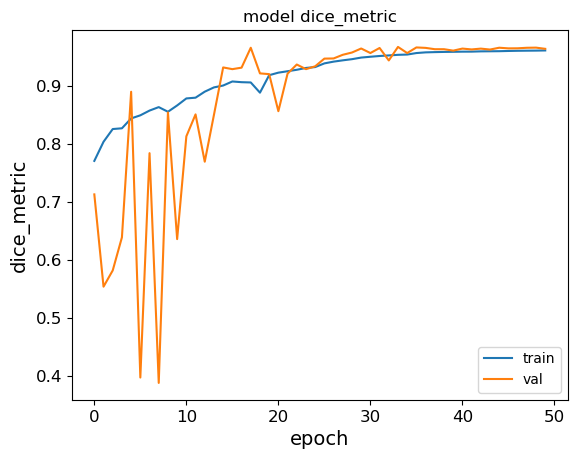

In [83]:
# summarize history for accuracy (dice_metric)
plt.plot(history.history['dice_metric'])
plt.plot(history.history['val_dice_metric'])
plt.title('model dice_metric')
plt.ylabel('dice_metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

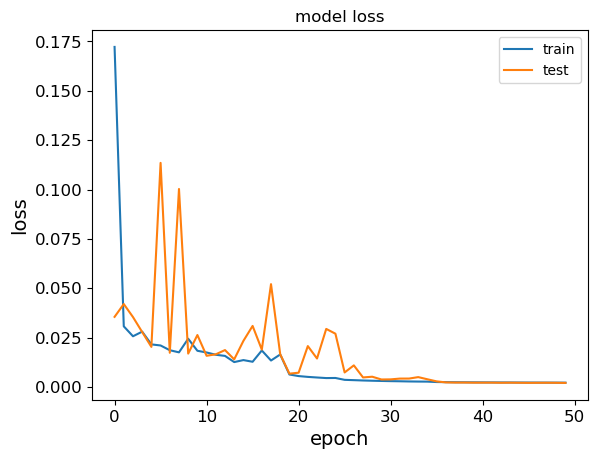

In [84]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Evaluating the model

In [ ]:
# best_model = load_model("best_unet_model_custgen_0.h5") # roll back to best

In [27]:
test_img_list = os.listdir(cropped_test_images_path)

In [50]:
X_test = read_images(cropped_test_images_path, test_img_list) / 148.

In [51]:
y_test = read_images(cropped_test_masks_path, test_img_list)

In [52]:
X_test.shape, y_test.shape

((520, 256, 256, 1), (520, 256, 256, 1))

In [53]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_pred_argmax.shape

17/17 [==============================] - 6s 369ms/step


(520, 256, 256)

In [54]:
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.86835927


In [55]:
# Calculating I0U for each class
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0] + values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1] + values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2] + values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

IoU for class1 is:  0.9903527
IoU for class2 is:  0.89959633
IoU for class3 is:  0.71512866


### **Results**:
- IoU for class1 is:  $0.99$
- IoU for class2 is:  $0.90$
- IoU for class3 is:  $0.715$
  
**Mean IoU** : $0.87$

## Testing

### Preparing predictions with voting

In [79]:
def get_patches(img_path, cropx=256,cropy=256):
    image = cv2.imread(img_path, 0)
    im_patches = crop_img(image, cropx, cropy)
    return np.expand_dims(np.array(im_patches), axis = 3), image.shape

def groupe_predictions(predictions, orig_shape):
    y,x = orig_shape[:2]
    assert (x>255 and y>255 and x<513 and y<513)
    cropx = 256
    cropy = 256
    p1 = np.zeros((y,x,3))
    p2 = np.zeros((y,x,3))
    p3 = np.zeros((y,x,3))
    p4 = np.zeros((y,x,3))
    
    p1[:cropy, :cropx, :] = predictions[0,...]
    p2[(y-cropy):, :cropx, :] = predictions[1,...]
    p3[:cropy, (x-cropx):, :] = predictions[2,...]
    p4[(y-cropy):, (x-cropx):, :] = predictions[3,...]
    
    im = np.max([p1, p2, p3, p4], axis=0)
    im_voted = np.argmax(im, axis=2)
    return im_voted

def model_predict(img_path, model):
    im_patches, orig_shape = get_patches(img_path)
    im_patches = im_patches / 148.
    predictions = model.predict(im_patches)
    prediction_voted = groupe_predictions(predictions, orig_shape)
    return prediction_voted

1/1 [==============================] - 0s 28ms/step


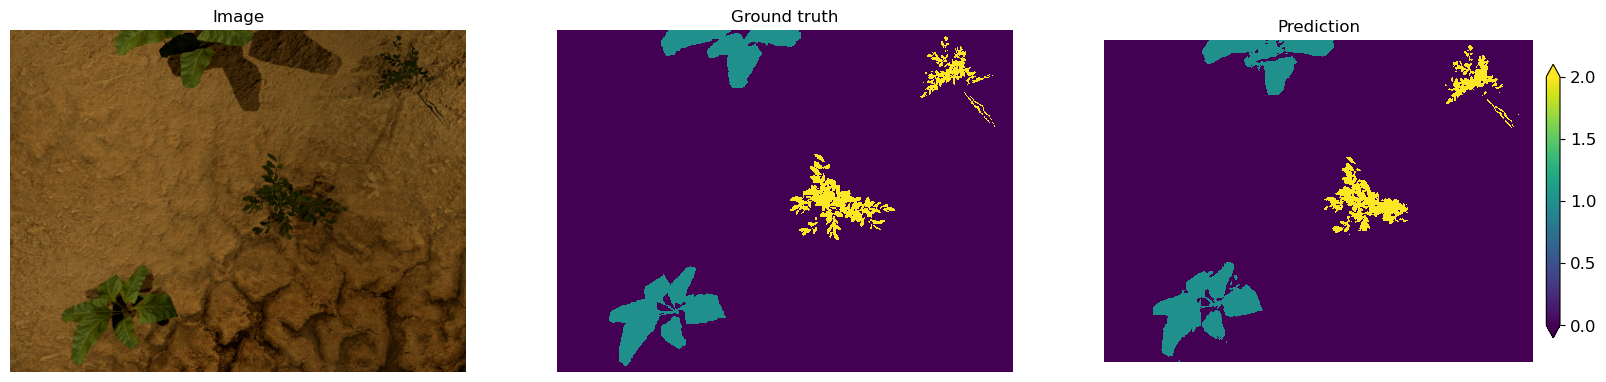

In [93]:
base_test_path = 'testing-images/'
im_test_path = base_test_path + 'sample0.png'
gt_test_path = base_test_path + 'gt0.png'
im = plt.imread(im_test_path)
gt = plt.imread(gt_test_path, 0)
prediction = model_predict(im_test_path, model)

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(im)
plt.axis('off')
plt.title('Image')

plt.subplot(132)
plot_image(gt, cmap='viridis')
plt.title('Ground truth')

plt.subplot(133)
plot_image(prediction, cmap='viridis')
plt.title('Prediction')

plt.colorbar(extend='both', fraction=0.03, pad=0.03)

fig_path = base_test_path + 'test0.png'
plt.savefig(fig_path, format='png', dpi=200)